### Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import warnings

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

### Загрузка данных и построение графика

Данные считываются из CSV-файла и преобразуются в временной ряд с накопленным итогом (cumulative sum).
Используется библиотека Seaborn для построения графика временного ряда.

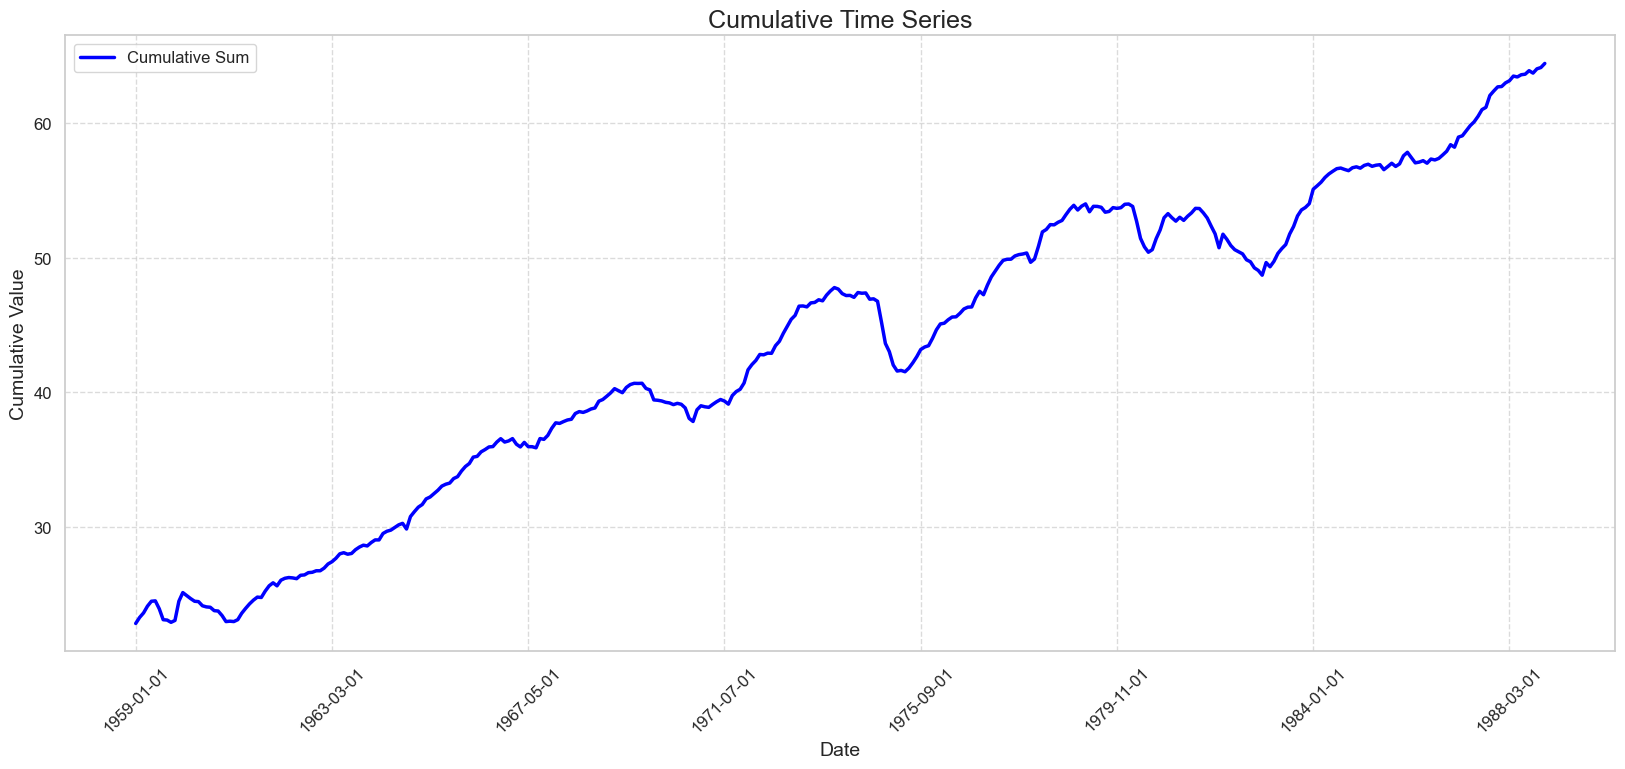

In [3]:
sns.set_theme(style="whitegrid")

data = pd.read_csv('training.csv')
ts = pd.Series(np.asarray(data['Value'], dtype=np.float64), index=data['Date'])
ts.cumsum()

plt.figure(figsize=(20, 8))
ts.plot(color="blue", linewidth=2.5, label="Cumulative Sum")

plt.title('Cumulative Time Series', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Value', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Функция для визуализации временного ряда с использованием скользящих статистик

Функция stats_plot строит три графика для временного ряда:

Оригинальный ряд (Original Row) — отображает исходные данные.
Скользящее среднее (Rolling Mean) — показывает тренд данных, вычисленный с использованием окна в 12 точек.
Скользящее стандартное отклонение (Rolling Standard Deviation) — визуализирует изменчивость данных во времени.

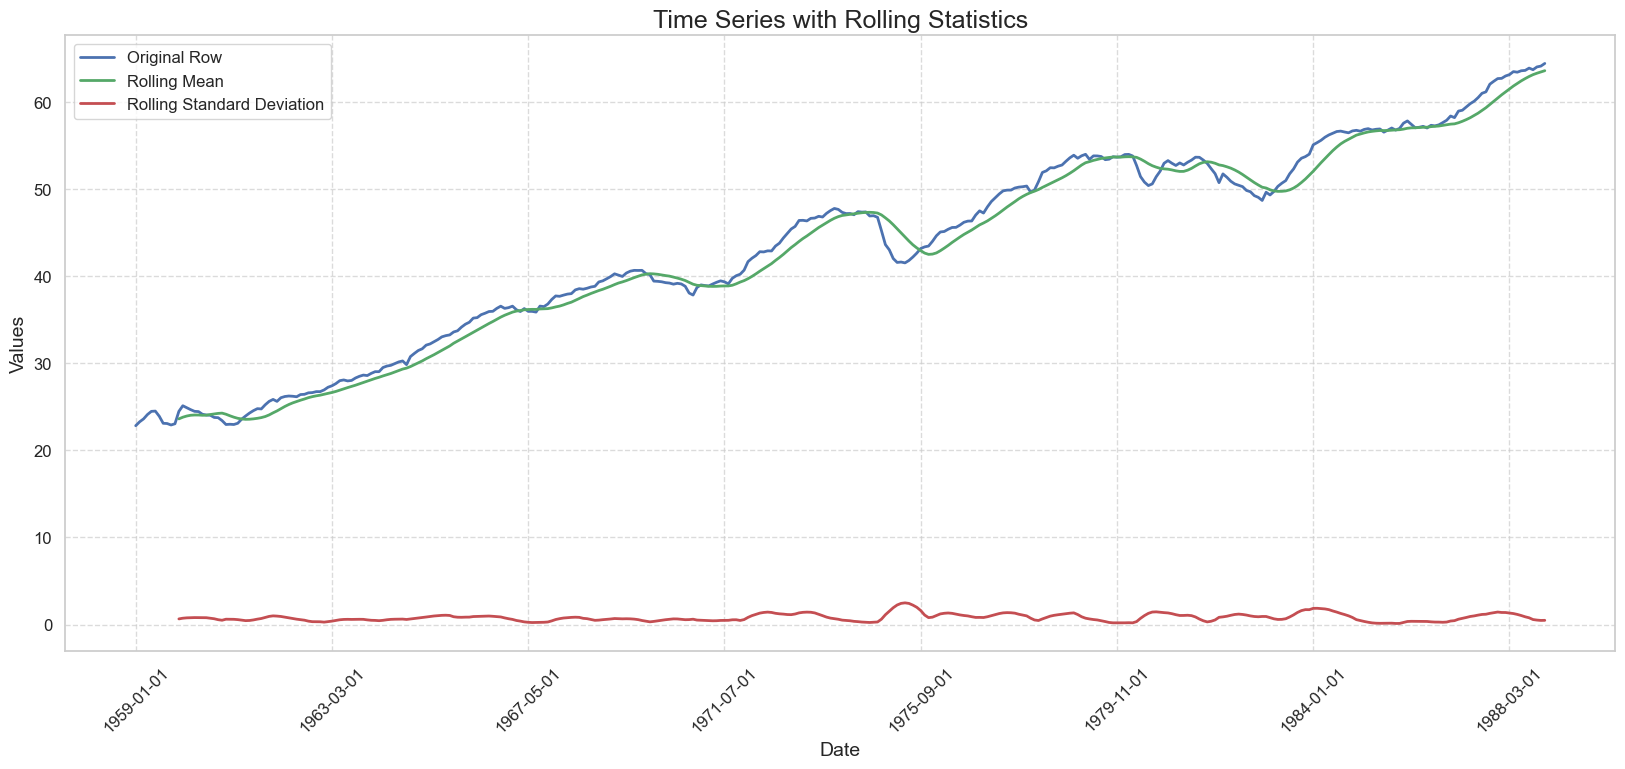

In [4]:
def stats_plot(ts):
    sns.set_theme(style="whitegrid")
    
    ts.plot(color='b', legend=True, figsize=(20, 8), label='Original Row', linewidth=2)
    ts.rolling(window=12, center=False).mean().plot(color='g', legend=True, label='Rolling Mean', linewidth=2)
    ts.rolling(window=12, center=False).std().plot(color='r', legend=True, label='Rolling Standard Deviation', linewidth=2)

    plt.title('Time Series with Rolling Statistics', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Values', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


stats_plot(ts)

### Тест Дики-Фуллера (Augmented Dickey-Fuller Test, ADF)

Функция df_test выполняет тест Дики-Фуллера (Augmented Dickey-Fuller Test, ADF) для проверки стационарности временного ряда. Стационарность означает, что статистические свойства временного ряда (среднее, дисперсия) не изменяются со временем. 

In [5]:
def df_test(ts, isPrint=True):
    sns.set_theme(style="whitegrid")

    test = sm.tsa.adfuller(ts)
    
    if isPrint:
        print(f"Статистика ADF: {test[0]:.4f}")
        print(f"p-значение: {test[1]:.4f}")
        print("Критические значения:")
        for key, value in test[4].items():
            print(f"    {key}: {value:.4f}")

    if test[0] > test[4]['5%']:
        if isPrint:
            print("\nРезультат: Ряд имеет единичные корни (не стационарен).")
        return False
    else:
        if isPrint:
            print("\nРезультат: Ряд не имеет единичных корней (стационарен).")
        return True

df_test(ts)

Статистика ADF: -0.2534
p-значение: 0.9319
Критические значения:
    1%: -3.4490
    5%: -2.8697
    10%: -2.5711

Результат: Ряд имеет единичные корни (не стационарен).


False


Тест Дики-Фуллера показал, что временной ряд не стационарен: статистика ADF (-0.2534) выше всех критических значений, а p-значение (0.9319) подтверждает отсутствие оснований для отклонения нулевой гипотезы о наличии единичных корней. Это указывает на тренды или сезонные эффекты в данных, требующие устранения. 

### Декомпозиция временного ряда на тренд, остатки и сезонность

Код ниже выполняет декомпозицию временного ряда, разделяя его на три компонента: тренд (долгосрочное направление), сезонность (периодические колебания) и остатки (шум). Для этого используется функция seasonal_decompose из библиотеки statsmodels. 

In [6]:
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
decom = seasonal_decompose(data.Value)

def plot_show(x, title=''):
    sns.set_theme(style="whitegrid")
    
    plt.figure(figsize=(20, 4))
    sns.lineplot(x=x.index, y=x.values, linewidth=2.5, color="blue")
    plt.title(title, fontsize=18)
    plt.xlabel('Дата', fontsize=14)
    plt.ylabel('Значение', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

trend = decom.trend
resid = decom.resid
seasonal = decom.seasonal

### Проверка стационарности тренда временного ряда

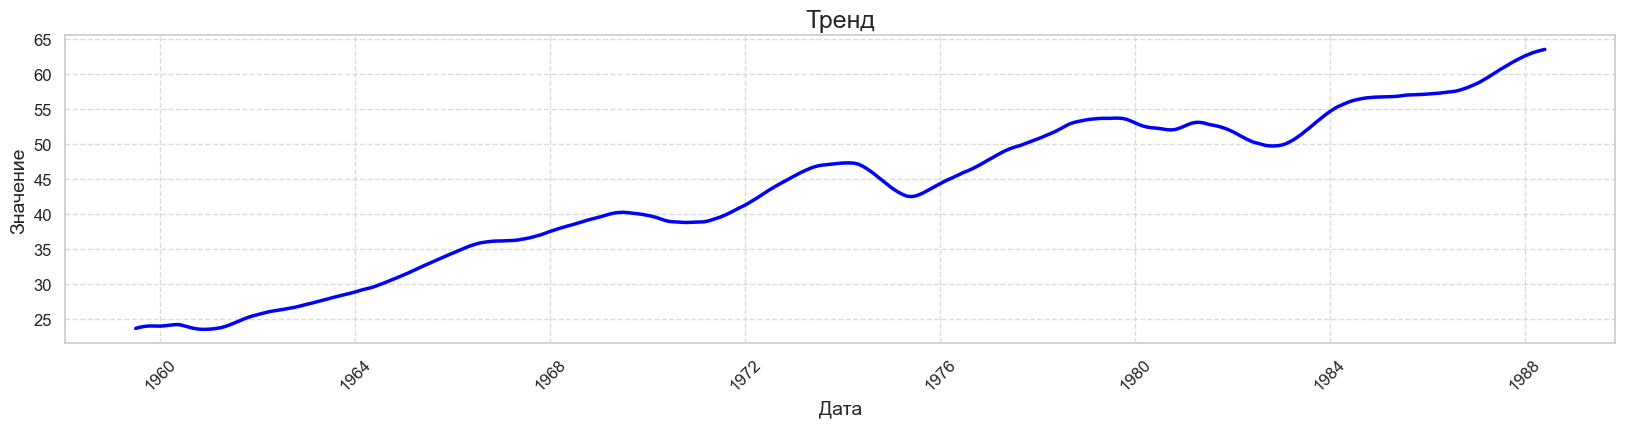

In [7]:
plot_show(trend, 'Тренд')

In [8]:
trend.dropna(inplace=True)
tsTrend = pd.Series(np.asarray(trend, dtype=np.float64), index=trend.index)

df_test(tsTrend)

Статистика ADF: -0.8616
p-значение: 0.8004
Критические значения:
    1%: -3.4503
    5%: -2.8703
    10%: -2.5715

Результат: Ряд имеет единичные корни (не стационарен).


False

### Проверка стационарности остатка временного ряда

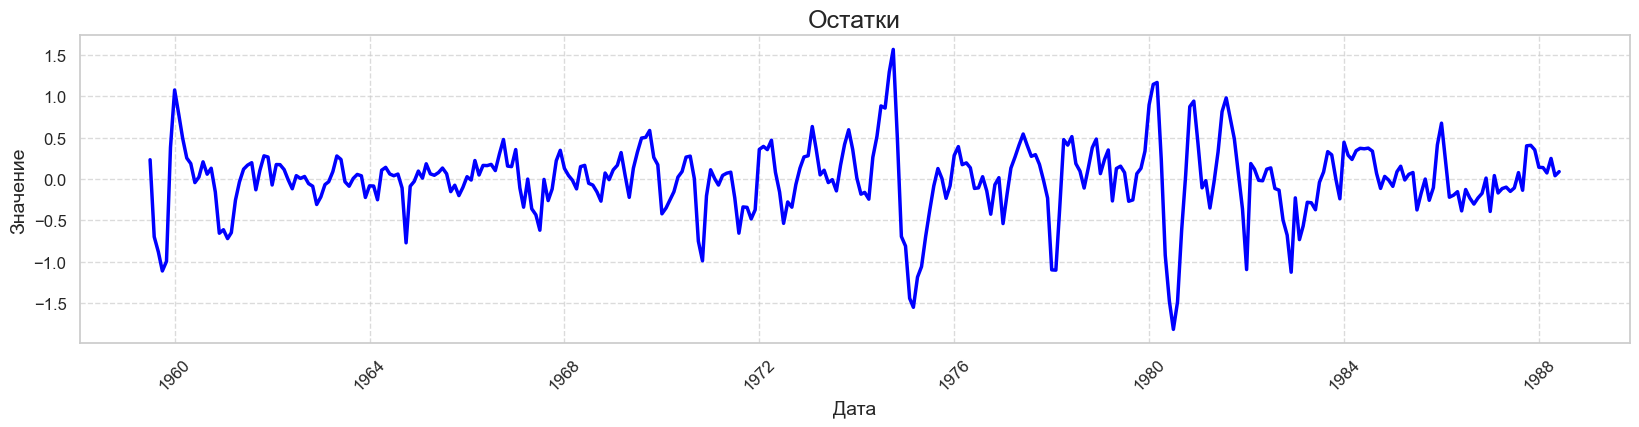

In [9]:
plot_show(resid, 'Остатки')

In [10]:
sns.set_theme(style="whitegrid")
resid.dropna(inplace=True)

tsResid = pd.Series(np.asarray(resid, dtype=np.float64), index=resid.index)

df_test(tsResid)

Статистика ADF: -7.4856
p-значение: 0.0000
Критические значения:
    1%: -3.4496
    5%: -2.8700
    10%: -2.5713

Результат: Ряд не имеет единичных корней (стационарен).


True

### Проверка стационарности сезонности временного ряда

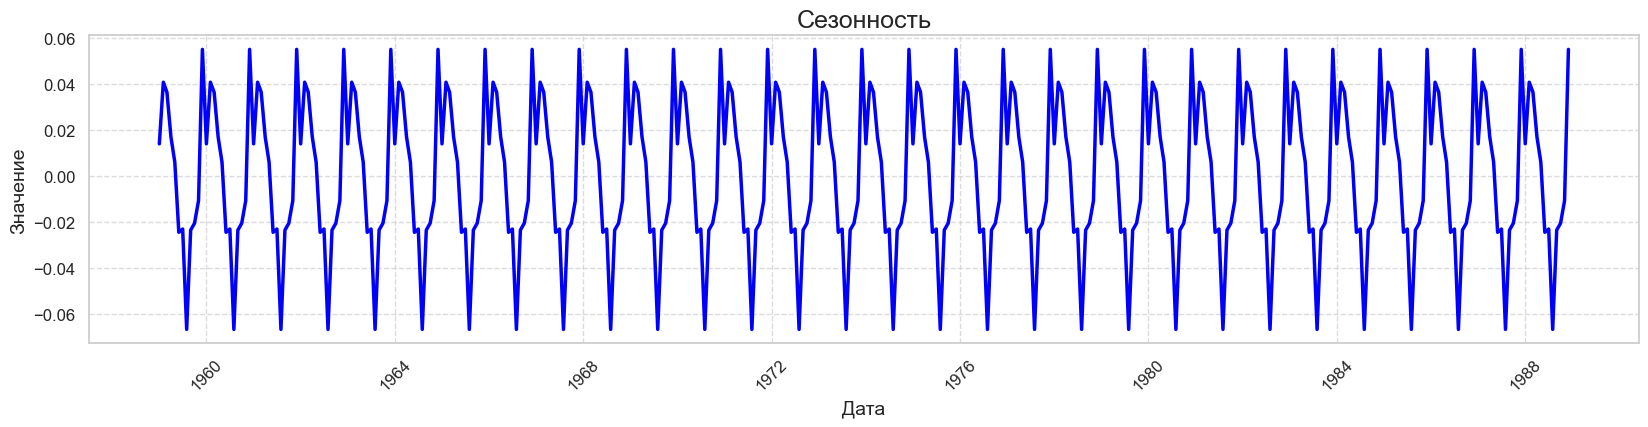

In [11]:
plot_show(seasonal, 'Сезонность')

In [12]:
seasonal.dropna(inplace=True)
tsSeasonal = pd.Series(np.asarray(seasonal, dtype=np.float64), index=seasonal.index)
tsSeasonal.cumsum()

df_test(tsSeasonal)

Статистика ADF: -505109009984783.8125
p-значение: 0.0000
Критические значения:
    1%: -3.4493
    5%: -2.8699
    10%: -2.5712

Результат: Ряд не имеет единичных корней (стационарен).


True

### Выводы:

В ходе анализа исходного временного ряда с использованием теста Дики-Фуллера и графиков было установлено следующее:

##### Тренд: 
Тест показал, что тренд временного ряда не является стационарным, так как статистика ADF превышает критические значения, а p-значение значительно выше допустимого уровня значимости (обычно это 0.05).

##### Остатки: 
Остатки временного ряда являются стационарными.

##### Сезонность: 
Сезонная компонента стационарна. Результаты теста и графики показывают, что периодические колебания данных стабильны и не зависят от временного сдвига.

### Определение порядка интеграции временного ряда

Функция ord_int определяет минимальный порядок дифференцирования временного ряда, необходимый для его стационарности. Это важный шаг при использовании модели ARIMA, где параметр d (порядок интеграции) указывает, сколько раз нужно дифференцировать ряд, чтобы он стал стационарным.

In [13]:
def ord_int(ts, prn=True):
    d = 0  

    while not df_test(ts, isPrint=False):  
        ts = ts.diff(periods=1).dropna()  
        d += 1

    if prn:
        print(f"Порядок интеграции: {d}")
        if d == 0:
            print("Ряд уже стационарен, дифференцирование не требуется.")
        else:
            print(f"Ряд становится стационарным после {d} дифференцирования.")
    
    return d


k = ord_int(ts)

Порядок интеграции: 1
Ряд становится стационарным после 1 дифференцирования.


### Анализ автокорреляции временного ряда (ACF и PACF)

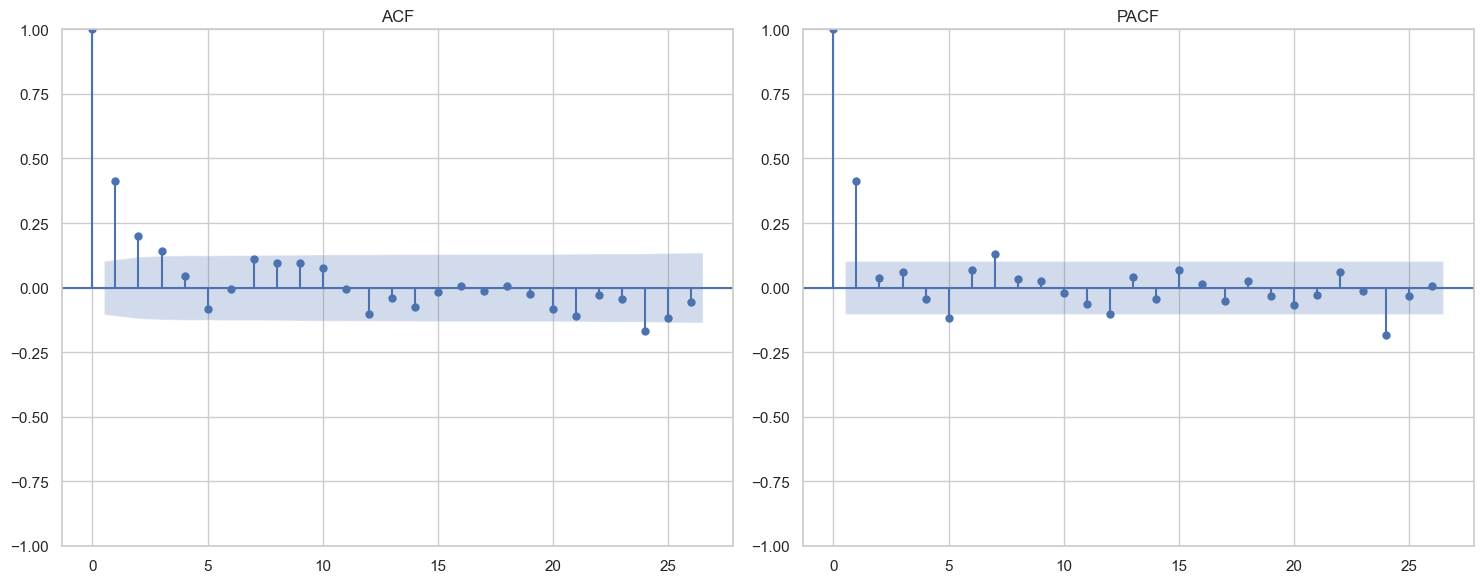

In [14]:
log_shift_ts = (np.log(ts) - np.log(ts).shift())
log_shift_ts.dropna(inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))  

plot_acf(log_shift_ts, ax=axes[0])
axes[0].set_title('ACF')

plot_pacf(log_shift_ts, ax=axes[1], method='ols')
axes[1].set_title('PACF')

plt.tight_layout() 
plt.show()

### Сравнение предсказаний модели ARIMA с разными параметрами (p, d, q) на тестовых данных

В коде этой части обучаются три модели ARIMA с различными параметрами (p, d, q) на тренировочных данных и строятся их предсказания для тестовых данных. Для каждой модели отображаются её предсказания на одном графике с реальными значениями тестовых данных. Рассчитываются метрики качества (RMSE и R²) для каждой модели.

In [15]:
warnings.filterwarnings('ignore')

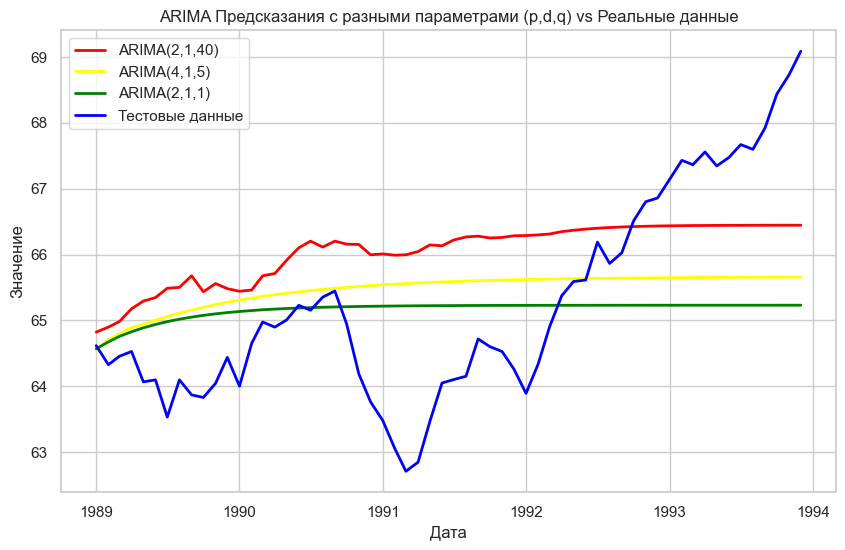

Метрики для всех моделей:
ARIMA(2,1,40) - RMSE: 1.5670, R^2: -0.0143, AIC: 277.7139
ARIMA(4,1,5) - RMSE: 1.4746, R^2: 0.1018, AIC: 259.3072
ARIMA(2,1,1) - RMSE: 1.5207, R^2: 0.0448, AIC: 256.8546


In [16]:
train_df = pd.read_csv('training.csv', parse_dates=['Date'], index_col='Date')
test_df = pd.read_csv('testing.csv', parse_dates=['Date'], index_col='Date')

train_df = train_df.interpolate(method='linear')
test_df = test_df.interpolate(method='linear')

params = [(2, 1, 40), (4, 1, 5), (2, 1, 1)] 

metrics = []

plt.figure(figsize=(10, 6))

colors = ['red', 'yellow', 'green']  

for idx, (p, d, q) in enumerate(params):

    model = ARIMA(train_df['Value'], order=(p, d, q))
    model_fit = model.fit()
    
    pred = model_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, typ='levels')
    
    rmse = np.sqrt(mean_squared_error(test_df['Value'], pred))
    r2 = r2_score(test_df['Value'], pred)
    
    aic = model_fit.aic
    
    metrics.append((p, d, q, rmse, r2, aic))
    
    plt.plot(test_df.index, pred, label=f'ARIMA({p},{d},{q})', color=colors[idx], linestyle='-', lw=2)

plt.plot(test_df.index, test_df['Value'], label='Тестовые данные', color='blue', linewidth=2)

plt.title('ARIMA Предсказания с разными параметрами (p,d,q) vs Реальные данные')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

print("Метрики для всех моделей:")
for p, d, q, rmse, r2, aic in metrics:
    print(f'ARIMA({p},{d},{q}) - RMSE: {rmse:.4f}, R^2: {r2:.4f}, AIC: {aic:.4f}')

### Выбор лучшей модели с помощью информацинного критерия Акаике

Для выбора лучшей модели ARIMA на основе информационного критерия Акаике (AIC) нужно использовать свойство, что модель с меньшим значением AIC считается более подходящей для данных.

АIC определяется как:

𝐴𝐼𝐶 = −2⋅log(𝐿)+2𝑘  

𝐿 — максимальное значение функции правдоподобия модели.

𝑘 — количество параметров в модели (включая параметры AR, I, MA).

In [17]:
best_model_aic = min(metrics, key=lambda x: x[5]) 
print(f'\nЛучшая модель по AIC: ARIMA({best_model_aic[0]},{best_model_aic[1]},{best_model_aic[2]}) с AIC = {best_model_aic[5]:.4f}')

best_model_r2 = max(metrics, key=lambda x: x[4])  
print(f'Лучшая модель по R²: ARIMA({best_model_r2[0]},{best_model_r2[1]},{best_model_r2[2]}) с R² = {best_model_r2[4]:.4f}')

p, d, q = best_model_aic[0], best_model_aic[1], best_model_aic[2]
model_aic = ARIMA(train_df['Value'], order=(p, d, q))
model_aic_fit = model_aic.fit()
pred_aic = model_aic_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, typ='levels')

rmse_best_aic = np.sqrt(mean_squared_error(test_df['Value'], pred_aic))
r2_best_aic = r2_score(test_df['Value'], pred_aic)

print(f'\nRMSE для лучшей модели по AIC: {rmse_best_aic:.4f}')
print(f'R² для лучшей модели по AIC: {r2_best_aic:.4f}')

p, d, q = best_model_r2[0], best_model_r2[1], best_model_r2[2]
model_r2 = ARIMA(train_df['Value'], order=(p, d, q))
model_r2_fit = model_r2.fit()
pred_r2 = model_r2_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, typ='levels')

rmse_best_r2 = np.sqrt(mean_squared_error(test_df['Value'], pred_r2))
r2_best_r2 = r2_score(test_df['Value'], pred_r2)

print(f'\nRMSE для лучшей модели по R²: {rmse_best_r2:.4f}')
print(f'R² для лучшей модели по R²: {r2_best_r2:.4f}')


Лучшая модель по AIC: ARIMA(2,1,1) с AIC = 256.8546
Лучшая модель по R²: ARIMA(4,1,5) с R² = 0.1018

RMSE для лучшей модели по AIC: 1.5207
R² для лучшей модели по AIC: 0.0448

RMSE для лучшей модели по R²: 1.4746
R² для лучшей модели по R²: 0.1018


### Выводы по работе

В ходе анализа были обучены несколько моделей ARIMA с разными значениями параметров (p, d, q). Для каждой модели были вычислены метрики RMSE, R² и AIC, что позволило оценить их качество с разных сторон. 
Модели были оценены по двум критериям: AIC (для выбора модели с минимальной сложностью и при этом наилучшим качеством) и R² (для оценки того, насколько хорошо модель объясняет данные). 
В результате были выбраны лучшие модели по AIC и по R².